Identifizierte Regions-Spalten (Features): ['cobra_lAlveus_Vgm', 'cobra_lAlveus_Vwm', 'cobra_lAmy_Vgm', 'cobra_lAmy_Vwm', 'cobra_lAntCerebLIII_Vgm', 'cobra_lAntCerebLIII_Vwm', 'cobra_lAntCerebLIV_Vgm', 'cobra_lAntCerebLIV_Vwm', 'cobra_lAntCerebLI_II_Vgm', 'cobra_lAntCerebLI_II_Vwm', 'cobra_lAntCerebLV_Vgm', 'cobra_lAntCerebLV_Vwm', 'cobra_lAntCerebWM_Vgm', 'cobra_lAntCerebWM_Vwm', 'cobra_lCA2_3_Vgm', 'cobra_lCA2_3_Vwm', 'cobra_lCA4_Vgm', 'cobra_lCA4_Vwm', 'cobra_lFimbra_Vgm', 'cobra_lFimbra_Vwm', 'cobra_lFor_Vgm', 'cobra_lFor_Vwm', 'cobra_lGloPal_Vgm', 'cobra_lGloPal_Vwm', 'cobra_lHCA1_Vgm', 'cobra_lHCA1_Vwm', 'cobra_lInfPostCerebLIX_Vgm', 'cobra_lInfPostCerebLIX_Vwm', 'cobra_lInfPostCerebLVIIIA_Vgm', 'cobra_lInfPostCerebLVIIIA_Vwm', 'cobra_lInfPostCerebLVIIIB_Vgm', 'cobra_lInfPostCerebLVIIIB_Vwm', 'cobra_lInfPostCerebLX_Vgm', 'cobra_lInfPostCerebLX_Vwm', 'cobra_lMamBody_Vgm', 'cobra_lMamBody_Vwm', 'cobra_lStratum_Vgm', 'cobra_lStratum_Vwm', 'cobra_lStriatum_Vgm', 'cobra_lStriatum_Vwm'

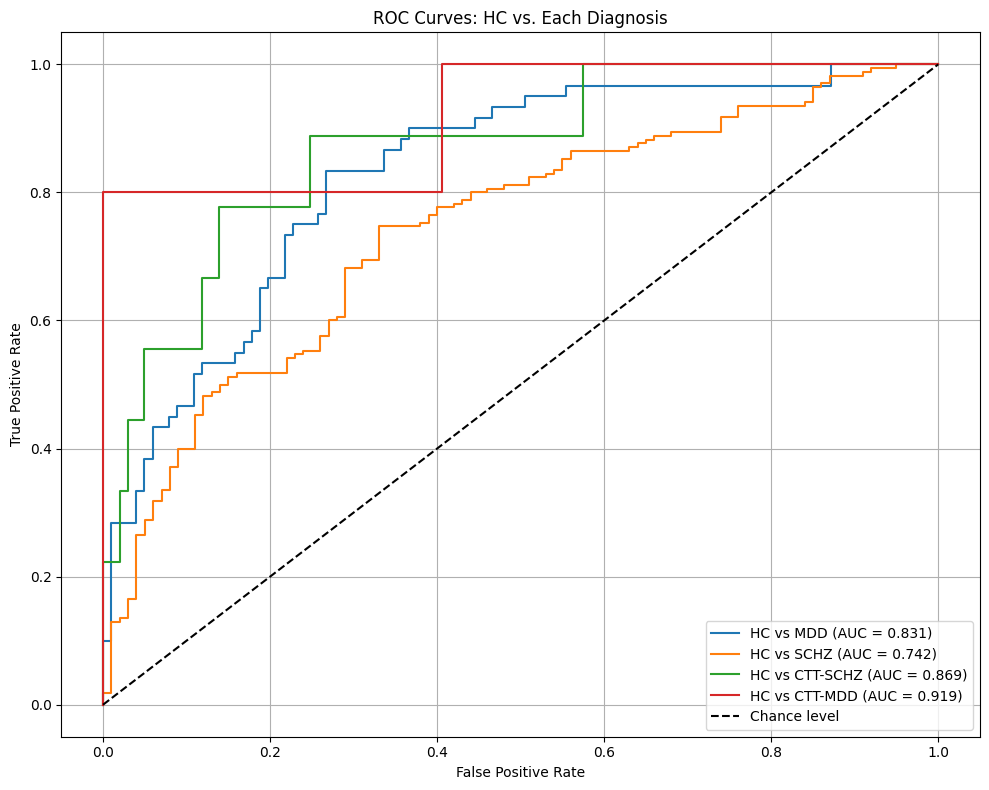

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score

# Load dataset
csv_path = "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/deviation_results_norm_results_HC_Vgm_Vwm_Vcsf_cobra_neuromorphometrics_20250530_1142_20250605_152329/deviation_scores_with_roi_names.csv"
df = pd.read_csv(csv_path)

# Verwende benannte Diagnosen
df["Diagnosis"] = df["Diagnosis"].astype("category")
diagnosis_list = df["Diagnosis"].unique()
non_hc_classes = [d for d in diagnosis_list if d != "HC"]

# Identifiziere die Spalten, die keine Features sein sollen (Metadaten)
# Basierend auf dem bereitgestellten Header:
# Filename, Diagnosis, Age, Sex, Dataset, reconstruction_error, reconstruction_error_std, kl_divergence, kl_divergence_std
# Die Features (Regionen) beginnen wahrscheinlich danach.
# Überprüfen Sie dies unbedingt mit df.columns, um sicherzustellen, dass die Indizes korrekt sind!
# Angenommen, die ersten 9 Spalten sind Metadaten (Index 0-8) und Features beginnen ab Index 9.
metadata_columns = [
    'Filename', 'Diagnosis', 'Age', 'Sex', 'Dataset',
    'reconstruction_error', 'reconstruction_error_std',
    'kl_divergence', 'kl_divergence_std'
]
# Alle Spalten, die NICHT in metadata_columns sind, sollen als Features verwendet werden.
# Dies ist der robusteste Weg, um die Regions-Spalten zu definieren.
all_columns = df.columns.tolist()
region_columns = [col for col in all_columns if col not in metadata_columns]

print(f"Identifizierte Regions-Spalten (Features): {region_columns}")
if not region_columns:
    print("Warnung: Keine Regions-Spalten nach Ausschluss der Metadaten-Spalten gefunden. Bitte überprüfen Sie 'metadata_columns'.")
    # Sie könnten hier auch eine Fehlermeldung ausgeben und das Skript beenden,
    # wenn das Fehlen von Regionen-Spalten kritisch ist.

# Plot vorbereiten
plt.figure(figsize=(10, 8)) # Größe angepasst für bessere Lesbarkeit der Legende

# Loop über jede Klasse ≠ HC
for diag in non_hc_classes:
    print(f"\n--- Analyse für: HC vs. {diag} ---")

    df_bin = df[df["Diagnosis"].isin(["HC", diag])].copy()
    df_bin["target"] = (df_bin["Diagnosis"] == diag).astype(int)

    # *** Hier ist die Änderung für X: ***
    # X verwendet nun alle identifizierten Regions-Spalten
    X = df_bin[region_columns]
    y = df_bin["target"]

    # Fügen Sie diese Überprüfungen hier ein:
    print(f"Gesamtanzahl der Samples für HC vs. {diag}: {len(df_bin)}")
    print(f"Verteilung vor dem Split (HC: {df_bin['target'].value_counts().get(0, 0)}, {diag}: {df_bin['target'].value_counts().get(1, 0)})")
    print(f"Anzahl der Features (Regionen): {X.shape[1]}") # Zeigt die Anzahl der verwendeten Features

    if len(df_bin['target'].unique()) < 2:
        print(f"Warnung: Nur eine Klasse ('HC' oder '{diag}') in den Daten für diese Paarung. Überspringe.")
        continue
    if len(df_bin) < 2:
        print(f"Warnung: Nicht genügend Datenpunkte für diese Paarung. Benötigt mindestens 2 Datenpunkte, aber hat {len(df_bin)}. Überspringe.")
        continue

    # Stellen Sie sicher, dass sowohl Trainings- als auch Testsets Beispiele beider Klassen enthalten.
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    except ValueError as e:
        print(f"Fehler beim Aufteilen der Daten für HC vs. {diag}: {e}")
        print(f"Anzahl HC: {y.value_counts().get(0, 0)}, Anzahl {diag}: {y.value_counts().get(1, 0)}")
        print("Möglicherweise sind nicht genügend Stichproben für eine stratifizierte Aufteilung vorhanden.")
        continue

    # Modell
    # Bei vielen Features kann es sinnvoll sein, Regularisierung anzupassen (C-Wert)
    # Ein kleinerer C-Wert bedeutet stärkere Regularisierung (vereinfacht das Modell)
    clf = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
    # Wenn Sie viele Features haben, könnten Sie auch L1-Regularisierung (lasso) in Betracht ziehen:
    # clf = LogisticRegression(random_state=42, solver='liblinear', penalty='l1', C=0.1, max_iter=1000)
    # C=1.0 ist der Standardwert; experimentieren Sie mit kleineren Werten wie 0.5, 0.1, 0.01
    clf.fit(X_train, y_train)

    # --- Hier beginnen die Ausgaben für die Kontrolle ---

    # 1. Koeffizienten des Modells
    # Jetzt gibt es einen Koeffizienten für jedes Feature (jede Region)
    print(f"Modell-Koeffizienten (erste 5 Koeffizienten): {clf.coef_[0][:5].round(4)}")
    if len(clf.coef_[0]) > 5:
        print(f"(... und {len(clf.coef_[0]) - 5} weitere Koeffizienten)")
    print(f"Modell-Intercept: {clf.intercept_[0]:.4f}")
    # Interpretation: Die Koeffizienten zeigen die Gewichtung jeder Region für die Klassifikation.
    # Positive Koeffizienten erhöhen die Wahrscheinlichkeit der Zielklasse, negative verringern sie.

    # 2. Vorhersagen des Modells auf dem Testset
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]

    print("\nErste 10 Vorhersagen auf dem Testset:")
    print(f"Echte Labels (y_test):       {y_test.values[:10]}")
    print(f"Vorhergesagte Labels (y_pred): {y_pred[:10]}")
    print(f"Vorhergesagte Wahrsch. (y_score): {[f'{s:.2f}' for s in y_score[:10]]}")

    # 3. Klassifikationsbericht
    print("\nKlassifikationsbericht:")
    current_target_names = ["HC", diag]
    print(classification_report(y_test, y_pred, target_names=current_target_names, zero_division=0))

    # 4. Konfusionsmatrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nKonfusionsmatrix:")
    print(f"[[TN, FP]\n [FN, TP]]")
    print(cm)

    # 5. AUC-Wert nochmals explizit ausgeben
    roc_auc = roc_auc_score(y_test, y_score)
    print(f"\nROC AUC Score: {roc_auc:.3f}")

    # --- ROC Plot (wie zuvor) ---
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f'HC vs {diag} (AUC = {roc_auc:.3f})')

# Finale Darstellung
plt.plot([0, 1], [0, 1], 'k--', label="Chance level")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: HC vs. Each Diagnosis")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

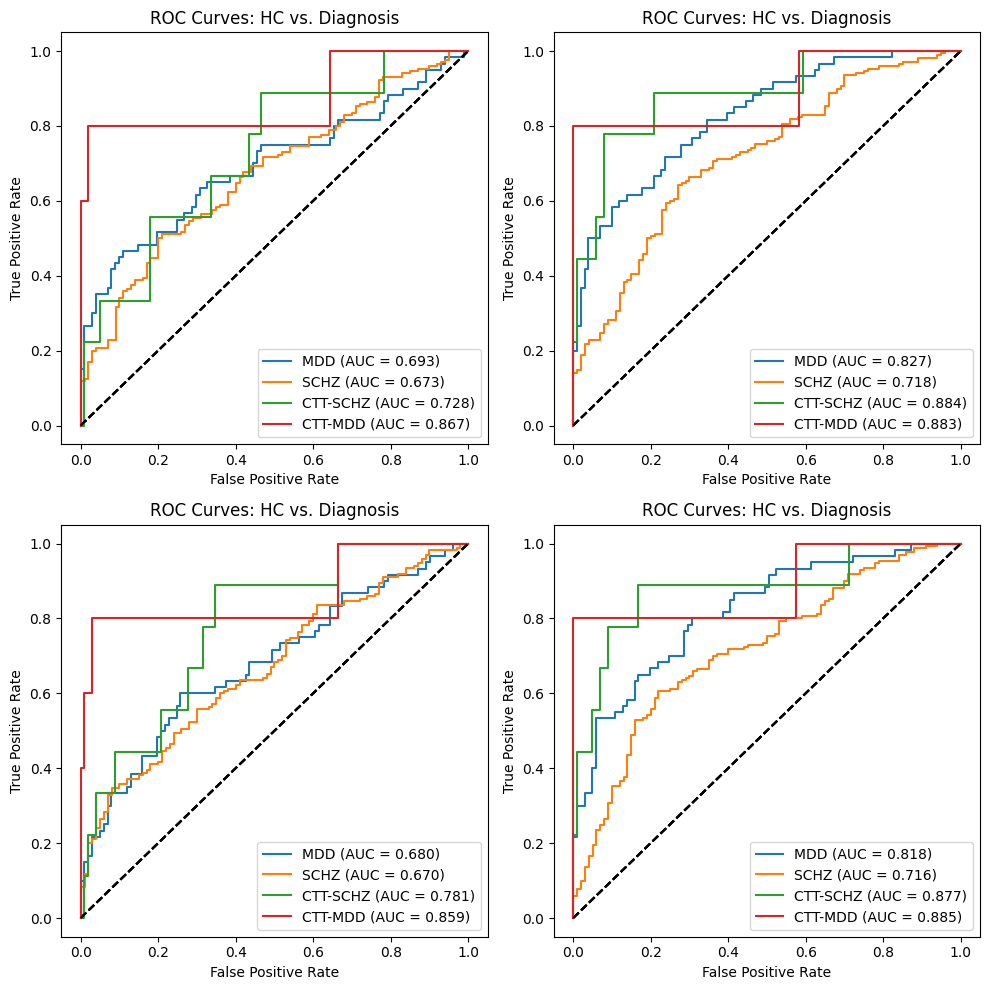

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score
import re

# Liste der CSV-Dateien
csv_paths = [
    "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/deviation_results_norm_results_HC_V_g_m_all_20250601_2108_20250606_131920/deviation_scores_with_roi_names.csv", #Vgm, all
    "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/deviation_results_norm_results_HC_Vgm_Vwm_Vcsf_all_20250530_1142_20250606_132210/deviation_scores_with_roi_names.csv", #all, all 
    "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/deviation_results_norm_results_HC_V_g_m_neuromorphometrics_cobra_lpba40_20250606_0349_20250618_132436/deviation_scores_with_roi_names.csv", #Vgm, neurom/lpba40
    "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/deviation_results_norm_results_HC_Vgm_Vwm_Vcsf_neuromorphometrics_cobra_lpba40_20250606_0540_20250613_183712/deviation_scores_with_roi_names.csv" #all, neurom/lpba40
]

rows = int(np.ceil(num_files / 2))  # Anzahl der Reihen automatisch berechnen
fig, axes = plt.subplots(rows, 2, figsize=(10, rows * 5))

# Verarbeitung jeder Datei
for i, csv_path in enumerate(csv_paths):
    df = pd.read_csv(csv_path)
    match = re.search(r"_([^_/]+)_\d{8}_\d{6}", csv_path)

    if match:
        plot_title = match.group(1)  # Extracted part (e.g., "V_g_m_all")
    else:
        plot_title = "Unknown"

    # Klassifikation: HC vs. andere Diagnosen
    df["Diagnosis"] = df["Diagnosis"].astype("category")
    diagnosis_list = df["Diagnosis"].unique()
    non_hc_classes = [d for d in diagnosis_list if d != "HC"]

    metadata_columns = ['Filename', 'Diagnosis', 'Age', 'Sex', 'Dataset', 'reconstruction_error', 'reconstruction_error_std', 'kl_divergence', 'kl_divergence_std']
    region_columns = [col for col in df.columns if col not in metadata_columns]

    for diag in non_hc_classes:
        df_bin = df[df["Diagnosis"].isin(["HC", diag])].copy()
        df_bin["target"] = (df_bin["Diagnosis"] == diag).astype(int)

        X = df_bin[region_columns]
        y = df_bin["target"]

        if len(df_bin['target'].unique()) < 2 or len(df_bin) < 2:
            continue

        # Train-Test-Split mit stratifiziertem Sampling
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
        except ValueError:
            continue

        clf = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:, 1]

        roc_auc = roc_auc_score(y_test, y_score)
        fpr, tpr, _ = roc_curve(y_test, y_score)

        row = i // 2  # Row index (integer division by 2)
        col = i % 2   # Column index (modulo operation for column)
        ax = axes[row, col]  # Correct subplot reference
        ax.plot(fpr, tpr, label=f'{diag} (AUC = {roc_auc:.3f})')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"ROC Curves: HC vs. Diagnosis")
        ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lade die Daten
csv_path_i = "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/deviation_results_norm_results_HC_V_g_m_all_20250601_2108_20250606_131920/deviation_scores_with_roi_names.csv" # Aktualisiere den Dateipfad
df = pd.read_csv(csv_path_i)

# Wähle nur die Z-Scores der Hirnregionen (also ohne Metadaten)
metadata_columns = ["Filename", "Diagnosis", "Age", "Sex", "Dataset"]
region_columns = [col for col in df.columns if col not in metadata_columns]

# Berechne die Korrelationsmatrix
corr_matrix = df[region_columns].corr()

# Visualisiere die Korrelationsmatrix mit Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Korrelationsmatrix der Hirnregionen")
plt.show()


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff5d265e9b0>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff5d265e9b0>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
